In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.stats as stats
import pandas as pd
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from abc import ABC, abstractmethod 

# Multi armed bandit algorithm with normal distributions

Let k arms with rewards following a Gaussian distribution $\mathcal{N}(\mu_i, 1)$. For simplicity the means $\mu_i$ are generated from a uniform distribution $\mathcal{U}[0, 1]$.

Two policies are implemented:


*   $\epsilon$-greedy,
*   Upper Confidence Bound.



## Bandits and policies

In [0]:
class Bandit:
  def __init__(self, k):
    self.k = k
    self.arm_mean = np.random.normal(0, 1, k)
    self.arm_distribution = [stats.norm(loc=mean, scale=1) for mean in self.arm_mean]
    self.trials = np.zeros(k)
    self.estimated_mean = np.zeros(k)

  def get_reward(self, action):
    reward = self.arm_distribution[action].rvs()
    return reward

  def update_estimation(self, action, reward):
    self.trials[action] += 1
    alpha = 1./self.trials[action]
    self.estimated_mean[action] += alpha * (reward - self.estimated_mean[action])

In [0]:
class GreedyPolicy(Bandit):
  def __init__(self, k, epsilon):
    Bandit.__init__(self, k)
    self.epsilon = epsilon

  def choose_action(self):
    rand_num = np.random.random()
    if self.epsilon > rand_num:
        action = np.random.randint(self.k)
    else:
        action = np.argmax(self.estimated_mean)
    return action   

In [0]:
class UBCPolicy(Bandit):
  def __init__(self, k):
    Bandit.__init__(self, k)
    self.radius = np.zeros(k)

  def choose_action(self):
    radius = np.sqrt(2 * np.log(1 + self.trials.sum()) / (1 + self.trials))
    self.radius = radius
    action = np.argmax(self.estimated_mean + radius)
    return action  

## Example of a 10-arm bandit

In [0]:
def run(n_iter, k, epsilon):
  if epsilon != None:
    bandit = GreedyPolicy(k, epsilon)
  else:
    bandit = UBCPolicy(k)

  max_mean = max(bandit.arm_mean)
  rewards = np.zeros(n_iter)
  regrets = np.zeros(n_iter+1)
  
  for it in range(n_iter):
    action = bandit.choose_action()
    reward = bandit.get_reward(action)
    bandit.update_estimation(action, reward)
    regrets[it+1] = regrets[it] + max_mean - reward
    rewards[it] = reward

  return regrets[1:], rewards  

In [0]:
n_iter = 1000
k = 10
n_exp = 200

In [0]:
def exp(n_exp, n_iter, k , epsilon=None):
  avg_regrets = np.zeros(n_iter)
  avg_rewards = np.zeros(n_iter)

  for i in tqdm(range(n_exp)):
    avg_regrets += run(n_iter, k, epsilon)[0]
    avg_rewards += run(n_iter, k, epsilon)[1]
  
  avg_regrets /= n_exp
  avg_rewards /= n_exp
  return avg_regrets, avg_rewards

In [54]:
reg_001, rew_001 = exp(n_exp, n_iter, k, 0.01)
reg_ucb, rew_ucb = exp(n_exp, n_iter, k)

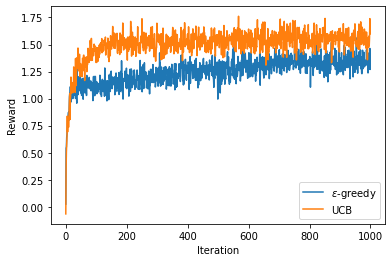

In [57]:
plt.plot(rew_001, label='$\epsilon$-greedy')
plt.plot(rew_ucb, label='UCB')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend();

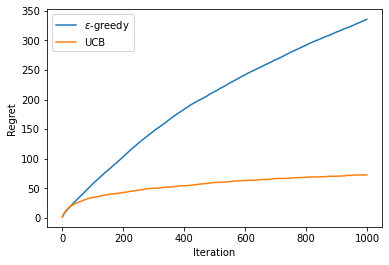

In [58]:
plt.plot(reg_001, label='$\epsilon$-greedy')
plt.plot(reg_ucb, label='UCB')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.legend();

# Bernoulli Bandit

In this setup, the likelihood $p(x | \theta)$ follows a Bernoulli. A natural choice for the prior is the Beta distribution since it is a conjugate prior to the Bernoulli distribution. In this context the posterior is also a Beta distribution that evolves according to: if $x$ is a win, the posterior becomes $Beta(\alpha +1, \beta)$, and if it is a fail, it becomes $Beta(\alpha, \beta +1)$.


In [0]:
class Bandit:
  def __init__(self, k):
    np.random.seed(0)
    self.arm_values = np.sort(np.random.rand(k))
    self.trials = np.zeros(k)
    self.wins = np.zeros(k)
    self.priors = [stats.beta(a=1, b=1) for i in range(k)]

  def choose_arm(self):
    theta_samples = np.array([distrib.rvs(1).item() for distrib in self.priors])
    return np.argmax(theta_samples)

  def update_distrib(self, action):
    self.trials[action] += 1
    self.wins[action] += int(np.random.rand() < self.arm_values[action])
    self.priors = [stats.beta(a=1+w, b=1+t-w) for t, w in zip(self.trials, self.wins)]

  def plot(self):
    fig, ax = plt.subplots()
    x = np.linspace(0.001, 0.999, 100)
    for prior in self.priors:
        y = prior.pdf(x)
        ax.plot(x, y)
        ax.fill_between(x, y, 0, alpha=0.2)
    ax.set_xlabel('x')
    ax.set_ylabel('Prior')

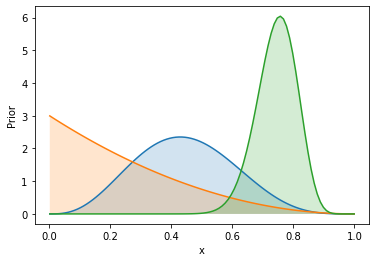

In [63]:
bandit = Bandit(3)
n = 50

for step in range(n):
  action = bandit.choose_arm()
  bandit.update_distrib(action)

bandit.plot()

# Contextual bandits

In this setup, the context influences the probabilities of the Bernoulli law of the arms. For convenience, we chose to model this effect by defining then as the result of a logistic regression over the context, where the parameters are unkown for the learner.
\begin{align*}
  p_k(x) = \frac{1}{1 + e^{- a_k x - \epsilon}}
\end{align*}

with $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

Again, for convenience, the context is only model by a unique variable $x$, and the logistic regression only has one parameter.

In [0]:
class Bandit:
  def __init__(self, k, epsilon=0.1):
    np.random.seed(1)
    self.arm_values = stats.lognorm.rvs(s=1, size=k)
    self.history = []
    self.k = k
    self.epsilon = epsilon

  def generate_context(self):
    n = len(self.history)
    return np.sin(0.1 * n)

  def choose_arm(self, x):
    prediction = np.zeros(self.k)
    df = pd.DataFrame(self.history, columns=['x', 'k', 'reward'])

    if df.groupby(['k', 'reward']).size().shape[0] == 2 * self.k:
      for i in range(self.k):
        data = df[df['k'] == i]
        X = data['x']
        y = data['reward']
        lr = LogisticRegression(fit_intercept=False).fit(X.values.reshape(-1, 1), y)
        prediction[i] = lr.predict_proba(np.array(x).reshape(-1, 1))[0][1]

      best_bandit = np.argmax(prediction)
    
    else:
      best_bandit = np.random.randint(self.k)

    rand_num = np.random.random()
    
    if self.epsilon > rand_num:
        return np.random.randint(self.k)
    else:
        return best_bandit

  def get_reward(self, x, action):
    noise = stats.norm.rvs()
    pk = expit(self.arm_values[action] * x + noise)
    rk = stats.bernoulli.rvs(pk)
    return rk

  def update_values(self, x, action, reward):
    update = {}
    update['x'] = x
    update['k'] = action
    update['reward'] = reward
    self.history.append(update)

  def plot(self):
    x = np.linspace(-5, 5, 200)
    for i, value in enumerate(self.arm_values):
      plt.plot(x, expit(value * x), label='arm ' + str(i))
    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.legend()

In [0]:
cmab = Bandit(2)

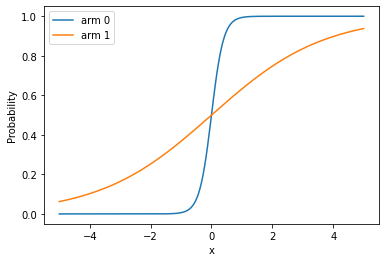

In [66]:
cmab.plot()

In [0]:
n = 100

for step in range(n):
  x = cmab.generate_context()
  action = cmab.choose_arm(x)
  reward = cmab.get_reward(x, action)
  cmab.update_values(x, action, reward)

In [0]:
data = pd.DataFrame(cmab.history)
data0 = data[data['k'] == 0]
data1 = data[data['k'] == 1]

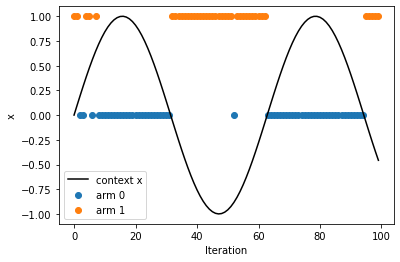

In [70]:
plt.plot(data['x'], color='black', label='context x')
plt.scatter(data0.index, data0['k'], label='arm 0')
plt.scatter(data1.index, data1['k'], label='arm 1')
plt.xlabel('Iteration')
plt.ylabel('x')
plt.legend();